## Stelios Giagkos f3352410
<h1>Part 1 Spectral Unmixing</h1>


#### Initial code given and the following Python libraries are used in this code:
The following Python libraries are used in this code:

In [1]:
import scipy.io as sio          # For handling MATLAB files and data I/O
import numpy as np              # For numerical operations on arrays and matrices
import scipy.optimize           # For optimization tasks
import matplotlib.pyplot as plt # For plotting data visualizations
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Initial Code given

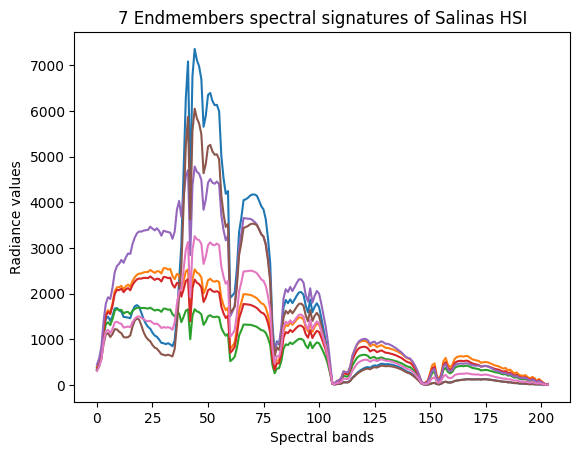

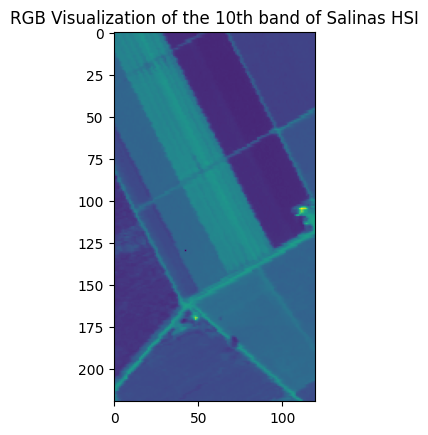

In [2]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
X = ends['salinas_endmembers']
cmap = plt.colormaps['gist_earth']  # New way to access colormap
fig = plt.figure()
plt.plot(X)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()



### Checking the Ground Truth

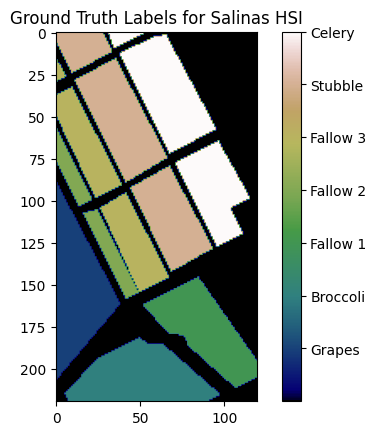

In [3]:


# Define the mapping for the endmember materials
material_mapping = {
    1: 'Grapes',
    2: 'Broccoli',
    3: 'Fallow 1',
    4: 'Fallow 2',
    5: 'Fallow 3',
    6: 'Stubble',
    7: 'Celery'
}

# Visualize the ground truth labels
gt_map = plt.figure()
plt.imshow(labels, cmap='gist_earth')  # Using a color map to distinguish different label values
plt.title('Ground Truth Labels for Salinas HSI')

# Add a colorbar with material labels
cbar = plt.colorbar()
cbar.set_ticks([1, 2, 3, 4, 5, 6, 7])
cbar.set_ticklabels([material_mapping[i] for i in range(1, 8)])

plt.show()


Only the **pixels with nonzero class** label will be taken into consideration in this
project.

In [4]:
# Convert labels to a boolean mask where non-zero entries are True
nonzero_mask = labels != 0

# Use the mask to select pixels in HSI with non-zero labels
y = HSI[nonzero_mask]


In [5]:
# Transpose y and check its shape
Y = y.T
Y.shape

(204, 16929)


# (A) Adopting the linear spectral unmixing hypothesis, y =X θ +η, derive the corresponding 7 abundance maps  using:

### (a) Least squares (as it was presented in the class) 

##### I) Derive the corresponding 7 abundance maps (one for each endmember/material) 


In [6]:
# Compute the matrix inverse for the least squares estimation
inv_X_unconstrained = np.linalg.inv(X.T @ X)

# Estimate theta values for all columns in Y 
theta_est_unconstrained = inv_X_unconstrained @ (X.T @ Y)

# Convert the result into a pandas DataFrame for better readability
# Each column corresponds to a pixel, and each row corresponds to an endmember (1-7)
thetas_df_unconstrained = pd.DataFrame(theta_est_unconstrained.T, columns=[f"θ{i+1}" for i in range(theta_est_unconstrained.shape[0])])

# Transpose the DataFrame to switch rows and columns
thetas_df_transposed_unconstrained = thetas_df_unconstrained.T

# Convert the transposed DataFrame to a NumPy array
thetas_unconstrained = thetas_df_transposed_unconstrained.to_numpy()
print("The parameters θ1, θ2, ..., θ7 using LS :\n")
thetas_df_transposed_unconstrained

The parameters θ1, θ2, ..., θ7 using LS :



,0,1,2,3,4,5,6,7,8,9,...,16919,16920,16921,16922,16923,16924,16925,16926,16927,16928
θ1,0.077699,0.060341,0.080087,0.041547,-0.054374,-0.010043,-0.021120,0.002370,0.036053,-0.003839,...,0.706375,0.982381,1.199637,1.034195,1.045292,0.930750,0.856298,0.891105,0.869139,0.865311
θ2,0.204796,0.229151,0.020585,-0.047352,-0.286703,0.106868,-0.169194,-0.181839,-0.238847,0.011387,...,-0.530236,-0.053677,0.273246,0.096197,0.001999,0.013997,-0.156962,-0.043565,-0.191671,-0.283551
θ3,0.074093,0.006274,-0.414264,-0.510885,-0.214724,0.411975,-0.350687,-0.417655,-0.578757,0.112916,...,0.572593,0.772469,0.515056,0.658366,-0.106389,0.404381,0.477664,0.389305,-0.098911,-0.299219
θ4,-0.274722,-0.333803,0.253918,0.413459,0.677602,-0.476851,0.444361,0.486880,0.730333,-0.128699,...,0.163356,-0.585568,-0.787052,-0.688249,0.092190,-0.344291,-0.196617,-0.275940,0.339732,0.601521
θ5,0.884397,1.000982,0.931843,0.932280,0.689286,1.045866,0.934527,0.938374,0.813324,0.966253,...,0.118841,0.191584,0.163294,0.173522,-0.022089,0.080980,0.063856,0.065390,-0.066375,-0.093518
θ6,-0.165657,-0.130529,-0.172228,-0.105297,0.016144,0.032122,0.001423,-0.039773,-0.111632,-0.030519,...,0.195094,-0.055048,-0.212471,-0.022574,-0.075536,0.070841,0.098099,0.041545,0.041783,0.042153
θ7,0.170421,0.107570,0.239107,0.232817,0.227383,-0.122223,0.136148,0.201717,0.361423,0.071881,...,-0.144970,-0.258964,-0.232605,-0.257444,0.024310,-0.132469,-0.073729,-0.026822,0.144525,0.198836


In [7]:
print("Shape of thetas array:", thetas_unconstrained.shape)

Shape of thetas array: (7, 16929)


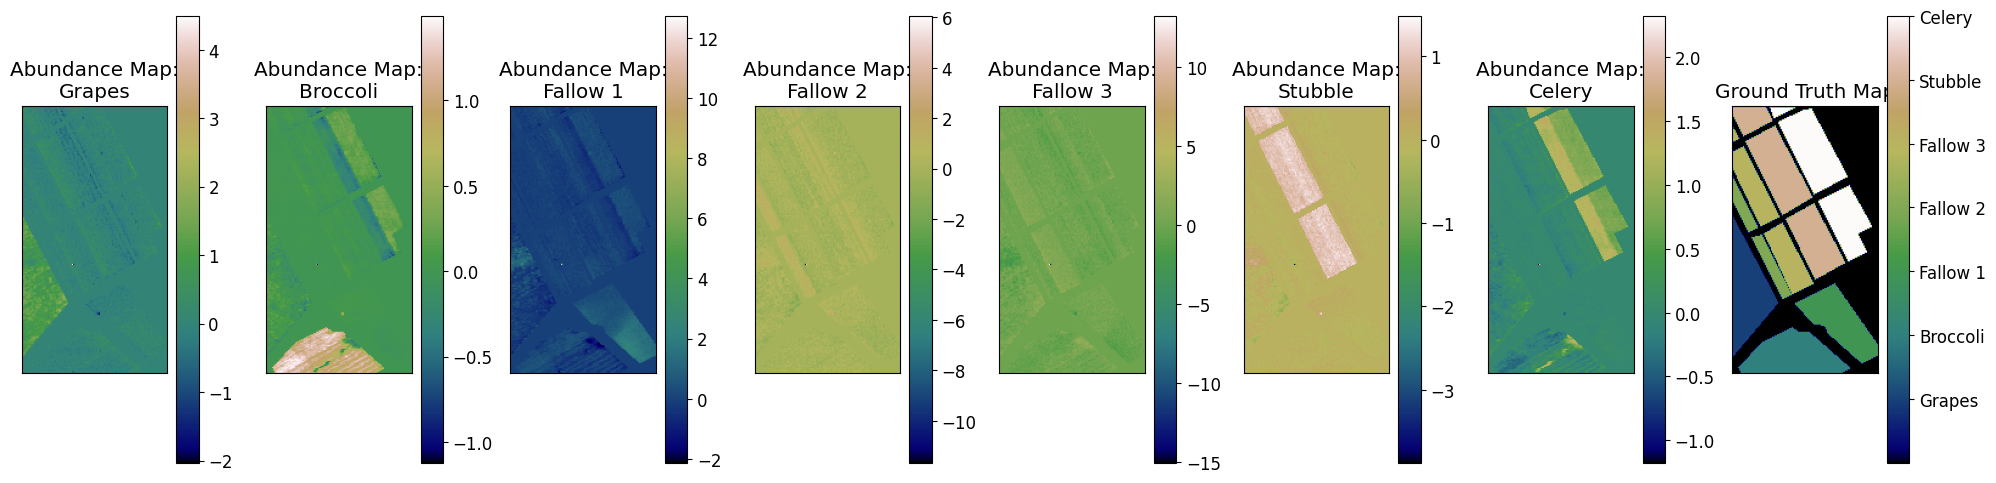

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Image dimensions and number of endmembers
image_height = 220
image_width = 120
num_X = 7

# Initialize thetas_for_each_pixel matrix (image_height, image_width, num_X)
thetas_for_each_pixel_unconstrained = np.zeros((image_height, image_width, num_X))

# Extract the number of valid pixels (where labels[i, j] != 0)
valid_indices_unconstrained = np.array(np.where(labels != 0)).T

# Extract the corresponding theta values for each valid pixel
for i, (row, col) in enumerate(valid_indices_unconstrained):
    thetas_for_each_pixel_unconstrained[row, col, :] = thetas_unconstrained[:, i]

# Set larger font sizes globally
plt.rcParams.update({'font.size': 12})

# Define endmember material names
endmember_materials = [
    "Grapes", "Broccoli", "Fallow 1", "Fallow 2",
    "Fallow 3", "Stubble", "Celery"
]

# Rearrange the abundance data to match the new order (Grapes first)
thetas_for_each_pixel_unconstrained = np.concatenate(
    [thetas_for_each_pixel_unconstrained[:, :, -1:], thetas_for_each_pixel_unconstrained[:, :, :-1]], axis=2
)

# Create a grid of subplots (1 row x 7 columns to fit 7 plots + ground truth)
abundance_map_unconstrained = plt.figure(figsize=(20, 5))

# Loop through each endmember to create the abundance maps
for k in range(num_X):
    plt.subplot(1, 8, k + 1)  # Create subplot for each endmember (7 plots)
    im = plt.imshow(thetas_for_each_pixel_unconstrained[:, :, k], cmap='gist_earth')
    plt.title(f"Abundance Map:\n{endmember_materials[k]}")
    plt.xticks([])  # Remove x-ticks for cleaner presentation
    plt.yticks([])  # Remove y-ticks for cleaner presentation
    plt.colorbar(im, orientation='vertical')

# Plot the ground truth map as the 8th column
plt.subplot(1, 8, num_X + 1)  # Create subplot for ground truth map (8th plot)
im_gt = plt.imshow(labels, cmap='gist_earth')
plt.title('Ground Truth Map')
plt.xticks([])
plt.yticks([])

# Define mapping for ground truth labels
material_mapping = {
    1: "Grapes",2: "Broccoli", 3: "Fallow 1", 4: "Fallow 2",
    5: "Fallow 3", 6: "Stubble", 7: "Celery", 
}

# Add a colorbar with material labels for the ground truth map
cbar = plt.colorbar(im_gt, orientation='vertical')
cbar.set_ticks(list(material_mapping.keys()))
cbar.set_ticklabels(list(material_mapping.values()))

# Adjust layout to prevent overlap and make it neat
plt.tight_layout()
plt.show()


##### (II) Compute the reconstruction error (for each (non-zero class label) pixel yicompute the quantity $||y𝑖 − 𝑋θ𝑖||^2$ and then take the average over those pixels).

In [9]:
Yest_unconstrained = np.dot(X, thetas_unconstrained)  # Perform matrix multiplication
print(Yest_unconstrained.shape)

reconstruction_errors_unconstrained = np.linalg.norm(Yest_unconstrained - Y, axis=0)**2  # Compute squared errors for each column (pixel)
average_error_unconstrained = np.mean(reconstruction_errors_unconstrained)  # Average over all errors
print(f"Average Reconstruction Error for LS: {average_error_unconstrained:.2f}")

(204, 16929)
Average Reconstruction Error for LS: 35058.88


### (b) Least squares imposing the sum-to-one constraint 

##### I) Derive the corresponding 7 abundance maps (one for each endmember/material) 


In [10]:
from scipy.optimize import minimize

theta_sum_to_one = []

# Define the least squares objective function
def objective(theta, X, y):
    return np.sum((X @ theta - y)**2)

# Define the sum-to-one constraint
def constraint(theta):
    return np.sum(theta) - 1.0

#For each pixel
for i in range(len(Y[0])):
    
    initial_theta = np.ones(7) / 7
    # Output: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

    # Perform constrained optimization
    result = minimize(objective, initial_theta, args=(X, Y[:, i]), constraints={'type': 'eq', 'fun': constraint})

    # Extract the estimated theta
    theta_i = result.x

    theta_sum_to_one.append(theta_i)

# Convert the list of theta estimates into a numpy array
theta_sum_to_one = np.array(theta_sum_to_one).T


In [11]:
print("The parameters θ1, θ2, ..., θ7 imposing sum-to-one constraint:\n")
theta_sum_to_one_df = pd.DataFrame(theta_sum_to_one, index=[f"θ{i+1}" for i in range(len(theta_sum_to_one))])
theta_sum_to_one_df

The parameters θ1, θ2, ..., θ7 imposing sum-to-one constraint:



,0,1,2,3,4,5,6,7,8,9,...,16919,16920,16921,16922,16923,16924,16925,16926,16927,16928
θ1,0.015090,-0.069342,-0.051624,-0.052302,0.063637,-0.036591,-0.074151,-0.019079,0.061759,-0.005178,...,0.881518,0.967639,1.024835,1.021257,0.958374,0.983016,1.004554,0.979739,0.951731,0.933450
θ2,0.114026,0.041152,-0.170355,-0.183407,-0.115647,0.068373,-0.246079,-0.212942,-0.201598,0.009434,...,-0.276360,-0.075059,0.019841,0.077430,-0.124009,0.089750,0.057939,0.084907,-0.071958,-0.184788
θ3,0.046341,-0.051170,-0.472607,-0.552467,-0.162526,0.400188,-0.374198,-0.427184,-0.567422,0.112288,...,0.650092,0.765908,0.437638,0.652603,-0.144902,0.427484,0.543262,0.428508,-0.062383,-0.269089
θ4,-0.135655,-0.045802,0.546423,0.621893,0.415617,-0.417858,0.562159,0.534550,0.673311,-0.125680,...,-0.225501,-0.552788,-0.398864,-0.659475,0.285233,-0.460302,-0.525771,-0.472705,0.156385,0.450264
θ5,0.863353,0.957405,0.887585,0.900742,0.728918,1.036937,0.916701,0.931158,0.821946,0.965793,...,0.177669,0.186621,0.104559,0.169165,-0.051299,0.098528,0.113651,0.095156,-0.038640,-0.070638
θ6,-0.088316,0.029671,-0.009523,0.010636,-0.129643,0.064915,0.066932,-0.013280,-0.143391,-0.028867,...,-0.021270,-0.036838,0.003467,-0.006594,0.031835,0.006273,-0.085049,-0.067950,-0.060248,-0.042024
θ7,0.185161,0.138086,0.270100,0.254905,0.199645,-0.115964,0.148635,0.206776,0.355395,0.072211,...,-0.186150,-0.255482,-0.191477,-0.254386,0.044767,-0.144748,-0.108585,-0.047655,0.125113,0.182824


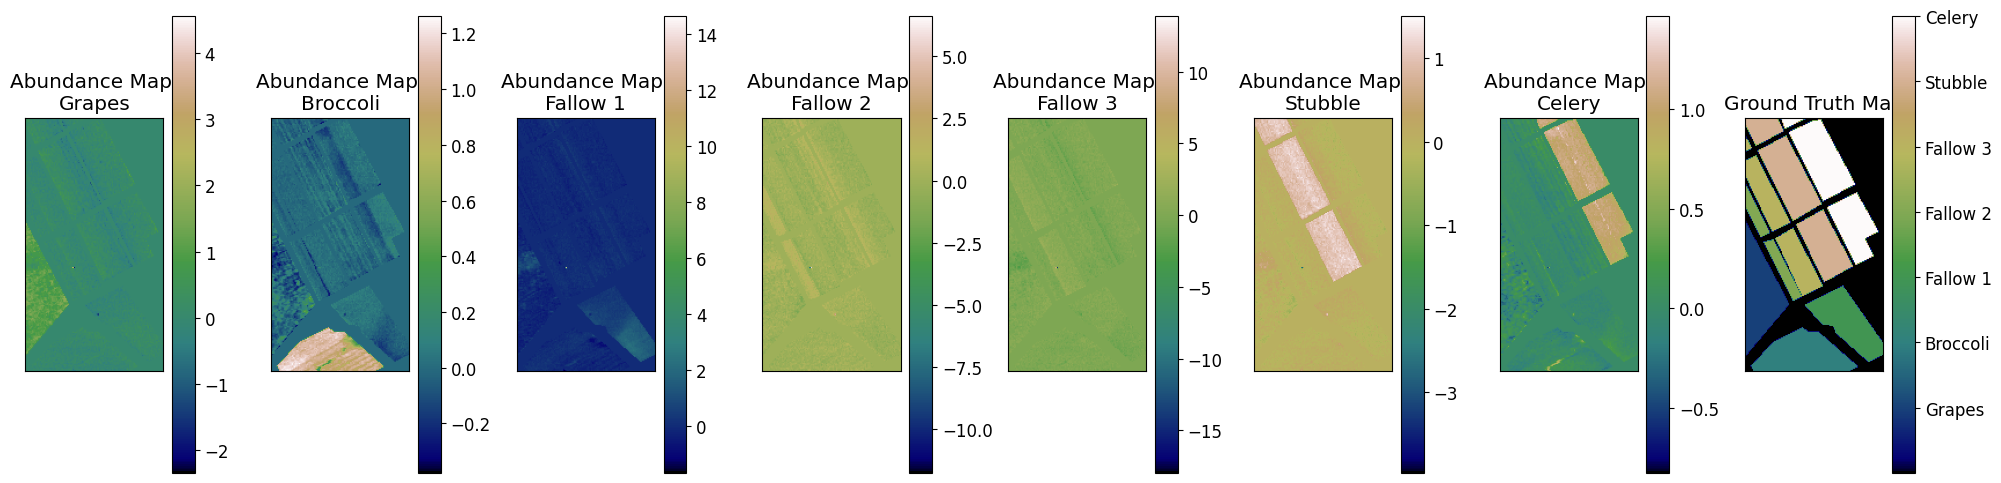

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Image dimensions and number of endmembers
image_height = 220
image_width = 120
num_X = 7

# Initialize thetas_for_each_pixel matrix (image_height, image_width, num_X)
theta_for_each_pixel_sum_to_one = np.zeros((image_height, image_width, num_X))

# Extract the number of valid pixels (where labels[i, j] != 0)
valid_indices_sum_to_one = np.array(np.where(labels != 0)).T

# Extract the corresponding theta values for each valid pixel
for i, (row, col) in enumerate(valid_indices_sum_to_one):
    theta_for_each_pixel_sum_to_one[row, col, :] = theta_sum_to_one[:, i]

# Set larger font sizes globally
plt.rcParams.update({'font.size': 12})

# Define endmember material names
endmember_materials = [
    "Grapes", "Broccoli", "Fallow 1", "Fallow 2",
    "Fallow 3", "Stubble", "Celery"
]

# Rearrange the abundance data to match the new order (Grapes first)
theta_for_each_pixel_sum_to_one = np.concatenate(
    [theta_for_each_pixel_sum_to_one[:, :, -1:], theta_for_each_pixel_sum_to_one[:, :, :-1]], axis=2
)

# Create a grid of subplots (1 row x 7 columns to fit 7 plots + ground truth)
abundance_map_sum_to_one = plt.figure(figsize=(20, 5))

# Loop through each endmember to create the abundance maps
for k in range(num_X):
    plt.subplot(1, 8, k + 1)  # Create subplot for each endmember (7 plots)
    im = plt.imshow(theta_for_each_pixel_sum_to_one[:, :, k], cmap='gist_earth')
    plt.title(f"Abundance Map:\n{endmember_materials[k]}")
    plt.xticks([])  # Remove x-ticks for cleaner presentation
    plt.yticks([])  # Remove y-ticks for cleaner presentation
    plt.colorbar(im, orientation='vertical')

# Plot the ground truth map as the 8th column
plt.subplot(1, 8, num_X + 1)  # Create subplot for ground truth map (8th plot)
im_gt = plt.imshow(labels, cmap='gist_earth')
plt.title('Ground Truth Map')
plt.xticks([])
plt.yticks([])

# Define mapping for ground truth labels
material_mapping = {
    1: "Grapes",2: "Broccoli", 3: "Fallow 1", 4: "Fallow 2",
    5: "Fallow 3", 6: "Stubble", 7: "Celery", 
}

# Add a colorbar with material labels for the ground truth map
cbar = plt.colorbar(im_gt, orientation='vertical')
cbar.set_ticks(list(material_mapping.keys()))
cbar.set_ticklabels(list(material_mapping.values()))

# Adjust layout to prevent overlap and make it neat
plt.tight_layout()
plt.show()


##### (II) Compute the reconstruction error (for each (non-zero class label) pixel yicompute the quantity $||y𝑖 − 𝑋θ𝑖||^2$ and then take the average over those pixels).

In [13]:
Yest_b = np.dot(X, theta_sum_to_one)  # Perform matrix multiplication
print(Yest_b.shape)

reconstruction_errors_b = np.linalg.norm(Yest_b - Y, axis=0)**2  # Compute squared errors for each column (pixel)
average_error_b = np.mean(reconstruction_errors_b)  # Average over all errors
print(f"Average Reconstruction Error for LS with sum to one constraint: {average_error_b:.2f}")

(204, 16929)
Average Reconstruction Error for LS with sum to one constraint: 43082.58


### (c) Least squares imposing the non-negativity constraint on the entries of θ

##### I) Derive the corresponding 7 abundance maps (one for each endmember/material) 


In [14]:
import numpy as np
import pandas as pd
from scipy.optimize import nnls

# Preallocate memory for theta_nnls (7 parameters, number of pixels)
theta_nnls = np.zeros((7, len(Y[0])))

# For each pixel (each column of Y)
for i in range(len(Y[0])):
    # Solve the non-negative least squares problem using nnls
    theta_nnls[:, i], _ = nnls(X, Y[:, i])

# Convert the numpy array to a pandas DataFrame
theta_nnls_df = pd.DataFrame(
    theta_nnls, 
    index=[f'θ{i+1}' for i in range(X.shape[1])],  # Row labels θ1, θ2, ..., θ7
    )

# Print the DataFrame
print("The parameters θ1, θ2, ..., θ7 estimated using NNLS:")
theta_nnls_df


The parameters θ1, θ2, ..., θ7 estimated using NNLS:


,0,1,2,3,4,5,6,7,8,9,...,16919,16920,16921,16922,16923,16924,16925,16926,16927,16928
θ1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.845652,0.899096,0.987082,0.975478,0.984166,0.966321,0.927568,0.915787,0.914824,0.921270
θ2,0.106490,0.007456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007538,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
θ3,0.000000,0.000000,0.000000,0.000000,0.206756,0.030192,0.000000,0.000000,0.000000,0.031673,...,0.137183,0.076320,0.000000,0.009346,0.000000,0.017306,0.050407,0.019164,0.027524,0.019770
θ4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000195,0.000000,0.000000,0.000000,0.000000,0.000000
θ5,0.832557,0.955169,0.988123,0.998336,0.815383,0.928367,0.986459,0.997012,0.954214,0.929541,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010781
θ6,0.000000,0.000000,0.000000,0.010923,0.000000,0.000000,0.012724,0.023181,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
θ7,0.054181,0.024531,0.015554,0.018625,0.000000,0.027151,0.000000,0.003421,0.073916,0.024950,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051301,0.050653,0.043180


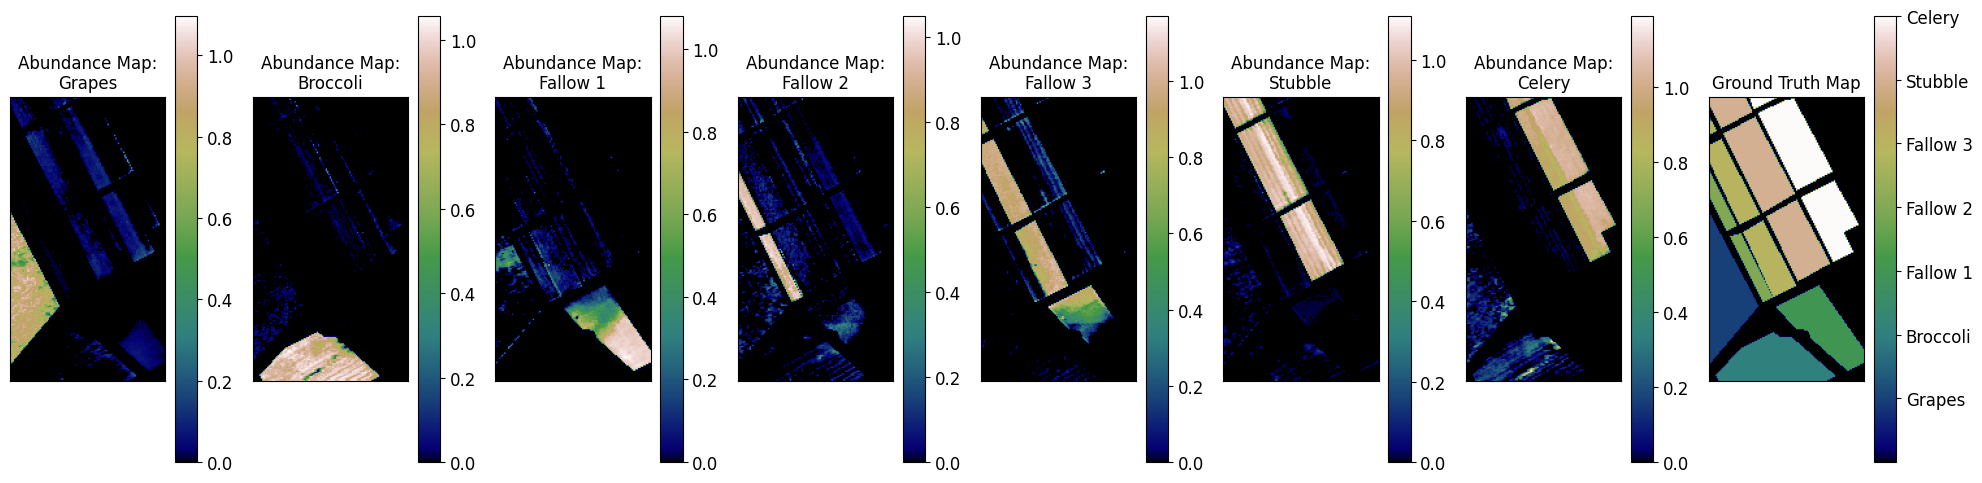

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Image dimensions and number of endmembers
image_height = 220
image_width = 120
num_X = 7

# Initialize thetas_for_each_pixel_nnls matrix (image_height, image_width, num_X)
thetas_for_each_pixel_nnls = np.zeros((image_height, image_width, num_X))

# Assuming labels and theta_nnls are already defined and available
valid_indices_nnls = np.array(np.where(labels != 0)).T

# Extract the corresponding theta values for each valid pixel (assuming theta_nnls is in (num_X, num_valid_pixels) format)
for i, (row, col) in enumerate(valid_indices_nnls):
    thetas_for_each_pixel_nnls[row, col, :] = theta_nnls[:, i]

# Define endmember material names
endmember_materials = [
    "Grapes", "Broccoli", "Fallow 1", 
    "Fallow 2", "Fallow 3", "Stubble", "Celery"
]

# Reorder the abundance data to place "Grapes" first
thetas_for_each_pixel_nnls = np.concatenate(
    [thetas_for_each_pixel_nnls[:, :, -1:], thetas_for_each_pixel_nnls[:, :, :-1]], axis=2
)

# Material mapping for class labels
material_mapping = {
    1: 'Grapes', 2: 'Broccoli', 3: 'Fallow 1', 
    4: 'Fallow 2', 5: 'Fallow 3', 6: 'Stubble', 7: 'Celery'
}

# Create a grid of subplots (1 row x 7 columns for abundance maps, 1 additional column for ground truth)
abundance_map_c = plt.figure(figsize=(20, 5))

# Loop through each endmember to create the abundance maps
for k in range(num_X):
    plt.subplot(1, 8, k + 1)
    im = plt.imshow(thetas_for_each_pixel_nnls[:, :, k], cmap='gist_earth')
    plt.title(f"Abundance Map:\n{endmember_materials[k]}", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(im, orientation='vertical')

# Plot the ground truth map as the 8th column
plt.subplot(1, 8, num_X + 1)
im_gt = plt.imshow(labels, cmap='gist_earth')
plt.title('Ground Truth Map', fontsize=12)
plt.xticks([])
plt.yticks([])

# Add a colorbar with material labels for the ground truth map
cbar = plt.colorbar(im_gt, orientation='vertical')
cbar.set_ticks(list(material_mapping.keys()))
cbar.set_ticklabels(list(material_mapping.values()))

# Adjust layout to prevent overlap and make it neat
plt.tight_layout()
plt.show()


##### (II) Compute the reconstruction error (for each (non-zero class label) pixel yi compute the quantity $||y𝑖 − 𝑋θ𝑖||^2$ and then take the average over those pixels).

In [16]:
Yest_c = np.dot(X, theta_nnls)  # Perform matrix multiplication
print(Yest_b.shape)

reconstruction_errors_c = np.linalg.norm(Yest_c - Y, axis=0)**2  # Compute squared errors for each column (pixel)
average_error_c = np.mean(reconstruction_errors_c)  # Average over all errors
print(f"Average Reconstruction Error for LS with non-negativity constraint: {average_error_c:.2f}")

(204, 16929)
Average Reconstruction Error for LS with non-negativity constraint: 156104.18


### (d) Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ.

##### I) Derive the corresponding 7 abundance maps (one for each endmember/material) 


In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import nnls

# Preallocate memory for theta_constrained (7 parameters, number of pixels)
theta_constrained = []

# For each pixel (each column of Y)
for i in range(len(Y[0])):
    # Solve the non-negative least squares problem
    theta_i, _ = nnls(X, Y[:, i])
    
    # Normalize theta_i to ensure it sums to one
    theta_i /= np.sum(theta_i)

    # Append the result for this pixel
    theta_constrained.append(theta_i)

# Convert the list of theta estimates into a numpy array
theta_constrained = np.array(theta_constrained).T

# Convert the numpy array to a pandas DataFrame
theta_constrained_df = pd.DataFrame(
    theta_constrained, 
    index=[f'θ{i+1}' for i in range(X.shape[1])],  # Row labels θ1, θ2, ..., θ7
)

# Print the DataFrame
print("The parameters θ1, θ2, ..., θ7 estimated imposing sum-to-one and non-negative entries:")
theta_constrained_df


The parameters θ1, θ2, ..., θ7 estimated imposing sum-to-one and non-negative entries:


,0,1,2,3,4,5,6,7,8,9,...,16919,16920,16921,16922,16923,16924,16925,16926,16927,16928
θ1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.860421,0.921757,1.0,0.99051,0.999801,0.982406,0.948458,0.928553,0.921272,0.925899
θ2,0.107216,0.007553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007585,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
θ3,0.000000,0.000000,0.000000,0.000000,0.202278,0.030630,0.000000,0.000000,0.000000,0.031874,...,0.139579,0.078243,0.0,0.00949,0.000000,0.017594,0.051542,0.019431,0.027718,0.019869
θ4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00000,0.000199,0.000000,0.000000,0.000000,0.000000,0.000000
θ5,0.838233,0.967597,0.984503,0.971254,0.797722,0.941825,0.987265,0.974012,0.928107,0.935433,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010835
θ6,0.000000,0.000000,0.000000,0.010626,0.000000,0.000000,0.012735,0.022647,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
θ7,0.054550,0.024850,0.015497,0.018119,0.000000,0.027545,0.000000,0.003342,0.071893,0.025108,...,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.052016,0.051010,0.043397


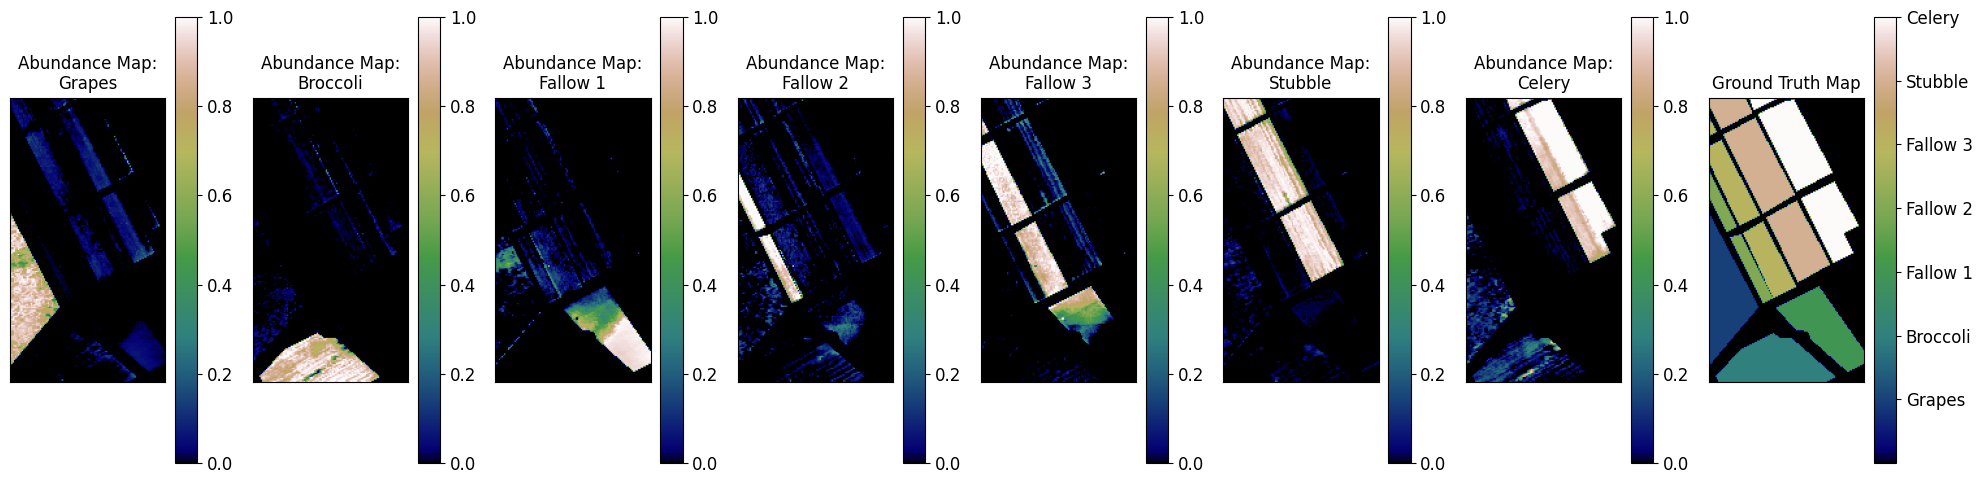

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions of the image
image_height = 220
image_width = 120
num_X = 7

# Initialize thetas_for_each_pixel_constrained matrix (image_height, image_width, num_X)
thetas_for_each_pixel_constrained = np.zeros((image_height, image_width, num_X))

# Assuming labels and theta_constrained are already defined and available
valid_indices_constrained = np.array(np.where(labels != 0)).T

# Extract the corresponding theta values for each valid pixel
for i, (row, col) in enumerate(valid_indices_constrained):
    thetas_for_each_pixel_constrained[row, col, :] = theta_constrained[:, i]

# Define endmember material names with "Grapes" first
endmember_materials = [
    "Grapes", "Broccoli", "Fallow 1", 
    "Fallow 2", "Fallow 3", "Stubble", "Celery"
]

# Reorder the abundance data to place "Grapes" first
thetas_for_each_pixel_constrained = np.concatenate(
    [thetas_for_each_pixel_constrained[:, :, -1:], thetas_for_each_pixel_constrained[:, :, :-1]], axis=2
)

# Material mapping for class labels
material_mapping = {
    1: 'Grapes', 2: 'Broccoli', 3: 'Fallow 1', 
    4: 'Fallow 2', 5: 'Fallow 3', 6: 'Stubble', 7: 'Celery'
}

# Set font size
plt.rcParams.update({'font.size': 12})

# Create a grid of subplots (1 row x 7 columns for abundance maps, 1 additional column for ground truth)
abundance_map_d = plt.figure(figsize=(20, 5))

# Loop through each endmember to create the abundance maps
for k in range(num_X):
    plt.subplot(1, 8, k + 1)
    im = plt.imshow(thetas_for_each_pixel_constrained[:, :, k], cmap='gist_earth')
    plt.title(f"Abundance Map:\n{endmember_materials[k]}", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(im, orientation='vertical')

# Plot the ground truth map as the 8th column
plt.subplot(1, 8, num_X + 1)
im_gt = plt.imshow(labels, cmap='gist_earth')
plt.title('Ground Truth Map', fontsize=12)
plt.xticks([])
plt.yticks([])

# Add a colorbar with material labels for the ground truth map
cbar = plt.colorbar(im_gt, orientation='vertical')
cbar.set_ticks(list(material_mapping.keys()))
cbar.set_ticklabels(list(material_mapping.values()))

# Adjust layout
plt.tight_layout()
plt.show()


##### (II) Compute the reconstruction error (for each (non-zero class label) pixel yi compute the quantity $||y𝑖 − 𝑋θ𝑖||^2$ and then take the average over those pixels).

In [19]:
Yest_d = np.dot(X, theta_constrained)  # Perform matrix multiplication
print(Yest_d.shape)

reconstruction_errors_d = np.linalg.norm(Yest_d - Y, axis=0)**2  # Compute squared errors for each column (pixel)
average_error_d = np.mean(reconstruction_errors_d)  # Average over all errors
print(f"Average Reconstruction Error for LS imposing both the non-negativity and the sum-to-one constraint on the entries of θ: {average_error_d:.2f}")

(204, 16929)
Average Reconstruction Error for LS imposing both the non-negativity and the sum-to-one constraint on the entries of θ: 1520302.94


### (e) LASSO, i.e., impose sparsity on θ via 𝑙1 norm minimization.

##### I) Derive the corresponding 7 abundance maps (one for each endmember/material) 


In [27]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Initialize an empty list to store theta values and a variable to track best alpha
theta_lasso = []
best_alpha_value = None
lowest_error = float('inf')

# Define a range of alpha values to experiment with
alpha_values = [0.01, 0.1,1,10]  # Adjust this range for finer tuning

for alpha in alpha_values:
    # Reset theta values for each alpha
    current_theta_lasso = []

    # For each pixel (each column of Y)
    for i in range(len(Y[0])):
        
        # Create a LASSO model with the current alpha
        lasso_model = Lasso(alpha=alpha, max_iter=100000)

        # Fit the LASSO model for the current pixel
        lasso_model.fit(X, Y[:, i])

        # Extract the estimated theta (coefficients)
        theta_i = lasso_model.coef_

        # Append the result to the current list
        current_theta_lasso.append(theta_i)
    
    # Calculate reconstruction error for the current alpha
    current_theta_lasso = np.array(current_theta_lasso).T
    Y_pred = X @ current_theta_lasso
    error = mean_squared_error(Y, Y_pred)
    
    # Update the best alpha if the current error is lower
    if error < lowest_error:
        lowest_error = error
        best_alpha_value = alpha
        theta_lasso = current_theta_lasso

# Convert the best theta values into a pandas DataFrame
theta_lasso_df = pd.DataFrame(
    theta_lasso, 
    index=[f'θ{i+1}' for i in range(X.shape[1])],  # Row labels θ1, θ2, ..., θ7
)

# Print the best alpha and the DataFrame with sparse theta values due to LASSO
print(f"Best alpha for sparse abundance maps: {best_alpha_value}")
print("The parameters θ1, θ2, ..., θ7 estimated using LASSO with sparsity:")
theta_lasso_df


Best alpha for sparse abundance maps: 10
The parameters θ1, θ2, ..., θ7 estimated using LASSO with sparsity:


,0,1,2,3,4,5,6,7,8,9,...,16919,16920,16921,16922,16923,16924,16925,16926,16927,16928
θ1,0.16,0.16,0.21,0.20,0.13,0.13,0.15,0.18,0.22,0.13,...,0.89,0.99,1.03,1.01,0.99,0.97,0.93,0.91,0.91,0.92
θ2,0.17,0.19,0.10,0.07,-0.06,0.04,-0.02,-0.05,-0.03,0.00,...,-0.39,-0.22,-0.00,-0.06,0.01,-0.00,-0.10,-0.03,-0.00,-0.01
θ3,-0.24,-0.39,-0.59,-0.60,0.00,-0.04,-0.36,-0.42,-0.45,-0.11,...,0.54,0.32,0.01,0.12,-0.01,0.10,0.29,0.18,0.11,0.07
θ4,0.05,0.07,0.33,0.35,0.19,-0.02,0.26,0.30,0.35,0.05,...,-0.00,0.01,0.03,-0.00,0.01,-0.03,-0.08,-0.08,-0.05,-0.02
θ5,0.79,0.88,0.88,0.91,0.77,0.92,0.94,0.96,0.86,0.91,...,0.12,0.06,-0.01,0.00,-0.00,-0.02,0.00,-0.01,-0.01,0.01
θ6,-0.30,-0.28,-0.36,-0.32,-0.21,-0.18,-0.23,-0.28,-0.34,-0.22,...,-0.04,-0.09,-0.03,-0.03,-0.00,0.00,-0.00,0.00,0.00,-0.00
θ7,0.32,0.30,0.34,0.30,0.17,0.09,0.17,0.23,0.33,0.19,...,-0.10,-0.07,-0.05,-0.04,-0.01,0.00,0.02,0.06,0.06,0.05


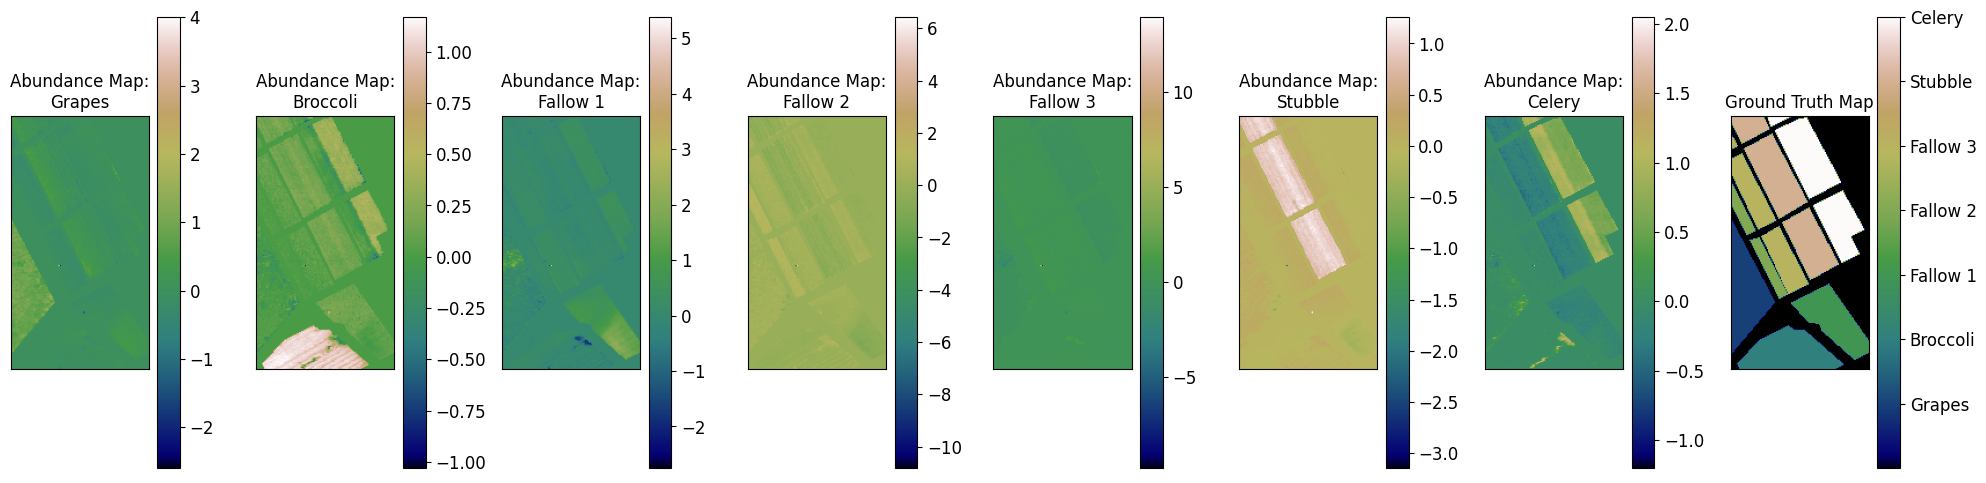

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions of the image
image_height = 220
image_width = 120
num_X = 7

# Initialize thetas_for_each_pixel_constrained matrix (image_height, image_width, num_X)
thetas_for_each_pixel_lasso= np.zeros((image_height, image_width, num_X))

# Assuming labels and theta_constrained are already defined and available
valid_indices_constrained = np.array(np.where(labels != 0)).T

# Extract the corresponding theta values for each valid pixel
for i, (row, col) in enumerate(valid_indices_constrained):
    thetas_for_each_pixel_lasso[row, col, :] = theta_lasso[:, i]

# Define endmember material names with "Grapes" first
endmember_materials = [
    "Grapes", "Broccoli", "Fallow 1", 
    "Fallow 2", "Fallow 3", "Stubble", "Celery"
]

# Reorder the abundance data to place "Grapes" first
thetas_for_each_pixel_lasso = np.concatenate(
    [thetas_for_each_pixel_lasso[:, :, -1:], thetas_for_each_pixel_lasso[:, :, :-1]], axis=2
)

# Material mapping for class labels
material_mapping = {
    1: 'Grapes', 2: 'Broccoli', 3: 'Fallow 1', 
    4: 'Fallow 2', 5: 'Fallow 3', 6: 'Stubble', 7: 'Celery'
}

# Set font size
plt.rcParams.update({'font.size': 12})

# Create a grid of subplots (1 row x 7 columns for abundance maps, 1 additional column for ground truth)
abundance_map_e = plt.figure(figsize=(20, 5))

# Loop through each endmember to create the abundance maps
for k in range(num_X):
    plt.subplot(1, 8, k + 1)
    im = plt.imshow(thetas_for_each_pixel_lasso[:, :, k], cmap='gist_earth')
    plt.title(f"Abundance Map:\n{endmember_materials[k]}", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(im, orientation='vertical')

# Plot the ground truth map as the 8th column
plt.subplot(1, 8, num_X + 1)
im_gt = plt.imshow(labels, cmap='gist_earth')
plt.title('Ground Truth Map', fontsize=12)
plt.xticks([])
plt.yticks([])

# Add a colorbar with material labels for the ground truth map
cbar = plt.colorbar(im_gt, orientation='vertical')
cbar.set_ticks(list(material_mapping.keys()))
cbar.set_ticklabels(list(material_mapping.values()))

# Adjust layout
plt.tight_layout()
plt.show()


##### (II) Compute the reconstruction error (for each (non-zero class label) pixel yi compute the quantity $||y𝑖 − 𝑋θ𝑖||^2$ and then take the average over those pixels).

In [32]:
Yest_e = np.dot(X, theta_lasso)  # Perform matrix multiplication
print(Yest_e.shape)

reconstruction_errors_e = np.linalg.norm(Yest_e - Y, axis=0)**2  # Compute squared errors for each column (pixel)
average_error_e = np.mean(reconstruction_errors_e)  # Average over all errors
print(f"Average Reconstruction Error for LS imposing LASSO, i.e., impose sparsity on θ via 𝑙1 norm minimization.: {average_error_e:.2f}")

(204, 16929)
Average Reconstruction Error for LS imposing LASSO, i.e., impose sparsity on θ via 𝑙1 norm minimization.: 56173.23


# (B) Compare the results obtained from the above five methods (focusing on the abundance maps and the reconstruction error) and comment briefly on them (utilize the class information given in “Salinas_gt.mat”).

In [33]:
# Create a DataFrame with methods and average errors
methods = [
    "Least Squares (Unconstrained)",
    "Least Squares (Sum-to-One)",
    "Least Squares (Non-negativity)",
    "Least Squares (Non-negativity + Sum-to-One)",
    "LASSO (Sparsity)"
]

average_errors = [
    average_error_unconstrained,
    average_error_b,
    average_error_c,
    average_error_d,
    average_error_e
]

# Create the DataFrame
error_df = pd.DataFrame({
    "Method": methods,
    "Average Error": average_errors
})

# Set pandas display option for non-scientific notation
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)




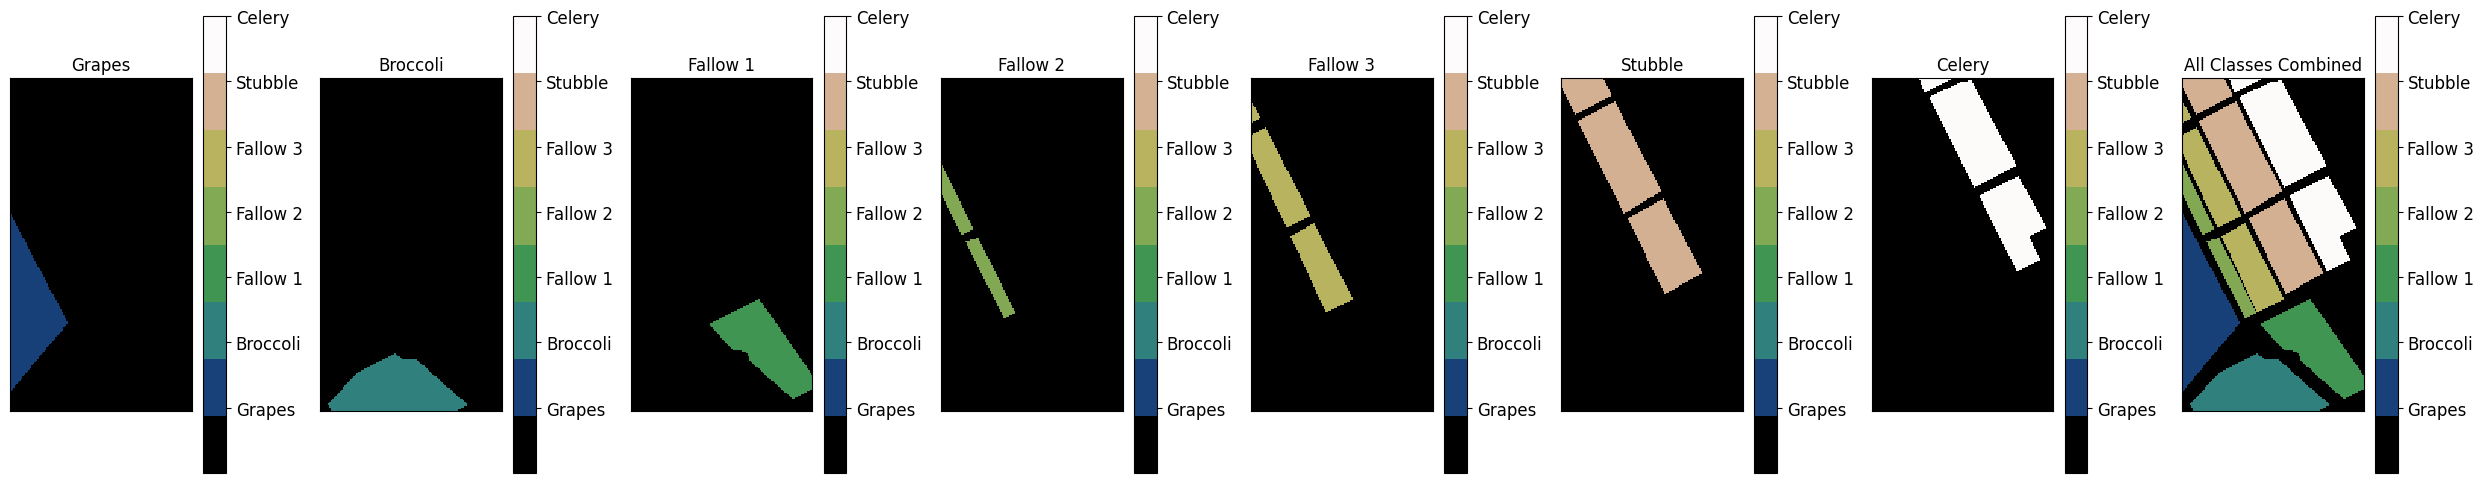

In [34]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Load the ground truth data from "Salinas_gt.mat"
data = sio.loadmat("Salinas_gt.mat")
ground_truth = data['salinas_gt']  # Replace 'salinas_gt' with the actual variable name in the .mat file

# Dimensions
num_classes = 7  # Number of classes (from 1 to 7)

# Material mapping for class labels
material_mapping = {
    1: 'Grapes',
    2: 'Broccoli',
    3: 'Fallow 1',
    4: 'Fallow 2',
    5: 'Fallow 3',
    6: 'Stubble',
    7: 'Celery'
}

# Set larger font sizes globally
plt.rcParams.update({'font.size': 12})

# Access the 'gist_earth' colormap directly without the deprecated function
cmap = plt.colormaps['gist_earth']  # New way to access colormap

# Create a discrete colormap with a fixed number of colors (using the 'gist_earth' colormap)
cmap_discrete = cmap(np.linspace(0, 1, num_classes + 1))

# Create a figure with an additional column for the composite plot of all classes
fig, axs = plt.subplots(1, num_classes + 1, figsize=(25, 5))  # Add one more column for the composite plot

# Create a mask that combines all classes
combined_mask = np.zeros_like(ground_truth)

# Loop through each class (1 to num_classes)
for i in range(1, num_classes + 1):  # Start from 1 to num_classes since classes are 1-based
    # Create a mask for each class (set pixels not belonging to the current class to 0 instead of NaN)
    class_mask = np.where(ground_truth == i, i, 0)  # Only show class i, others are set to 0
    
    # Plot each class in a separate subplot
    ax = axs[i - 1]  # Adjust indexing for the subplots
    im = ax.imshow(class_mask, cmap=plt.cm.colors.ListedColormap(cmap_discrete), interpolation='none', vmin=0, vmax=num_classes)
    
    # Set the title for each subplot (showing the class name)
    ax.set_title(f"{material_mapping[i]}", fontsize=12)  # Use material names as titles
    
    # Remove ticks for cleaner presentation
    ax.set_xticks([]) 
    ax.set_yticks([])

    # Add colorbar with the material name as label
    cbar = fig.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_ticks(np.arange(1, num_classes + 1))  # Set ticks to class labels
    cbar.set_ticklabels([material_mapping[i] for i in range(1, num_classes + 1)])

    # Update the combined mask to include this class
    combined_mask = np.maximum(combined_mask, class_mask)

# Plot the combined classes mask in the last column
ax_combined = axs[num_classes]  # Last column for the combined plot
im_combined = ax_combined.imshow(combined_mask, cmap=plt.cm.colors.ListedColormap(cmap_discrete), interpolation='none', vmin=0, vmax=num_classes)

# Set the title for the combined plot
ax_combined.set_title("All Classes Combined", fontsize=12)

# Remove ticks for cleaner presentation
ax_combined.set_xticks([]) 
ax_combined.set_yticks([])

# Add colorbar for the combined plot
cbar_combined = fig.colorbar(im_combined, ax=ax_combined, orientation='vertical')
cbar_combined.set_ticks(np.arange(1, num_classes + 1))  # Set ticks to class labels
cbar_combined.set_ticklabels([material_mapping[i] for i in range(1, num_classes + 1)])

# Adjust layout
plt.tight_layout()

# Display the figure
plt.show()


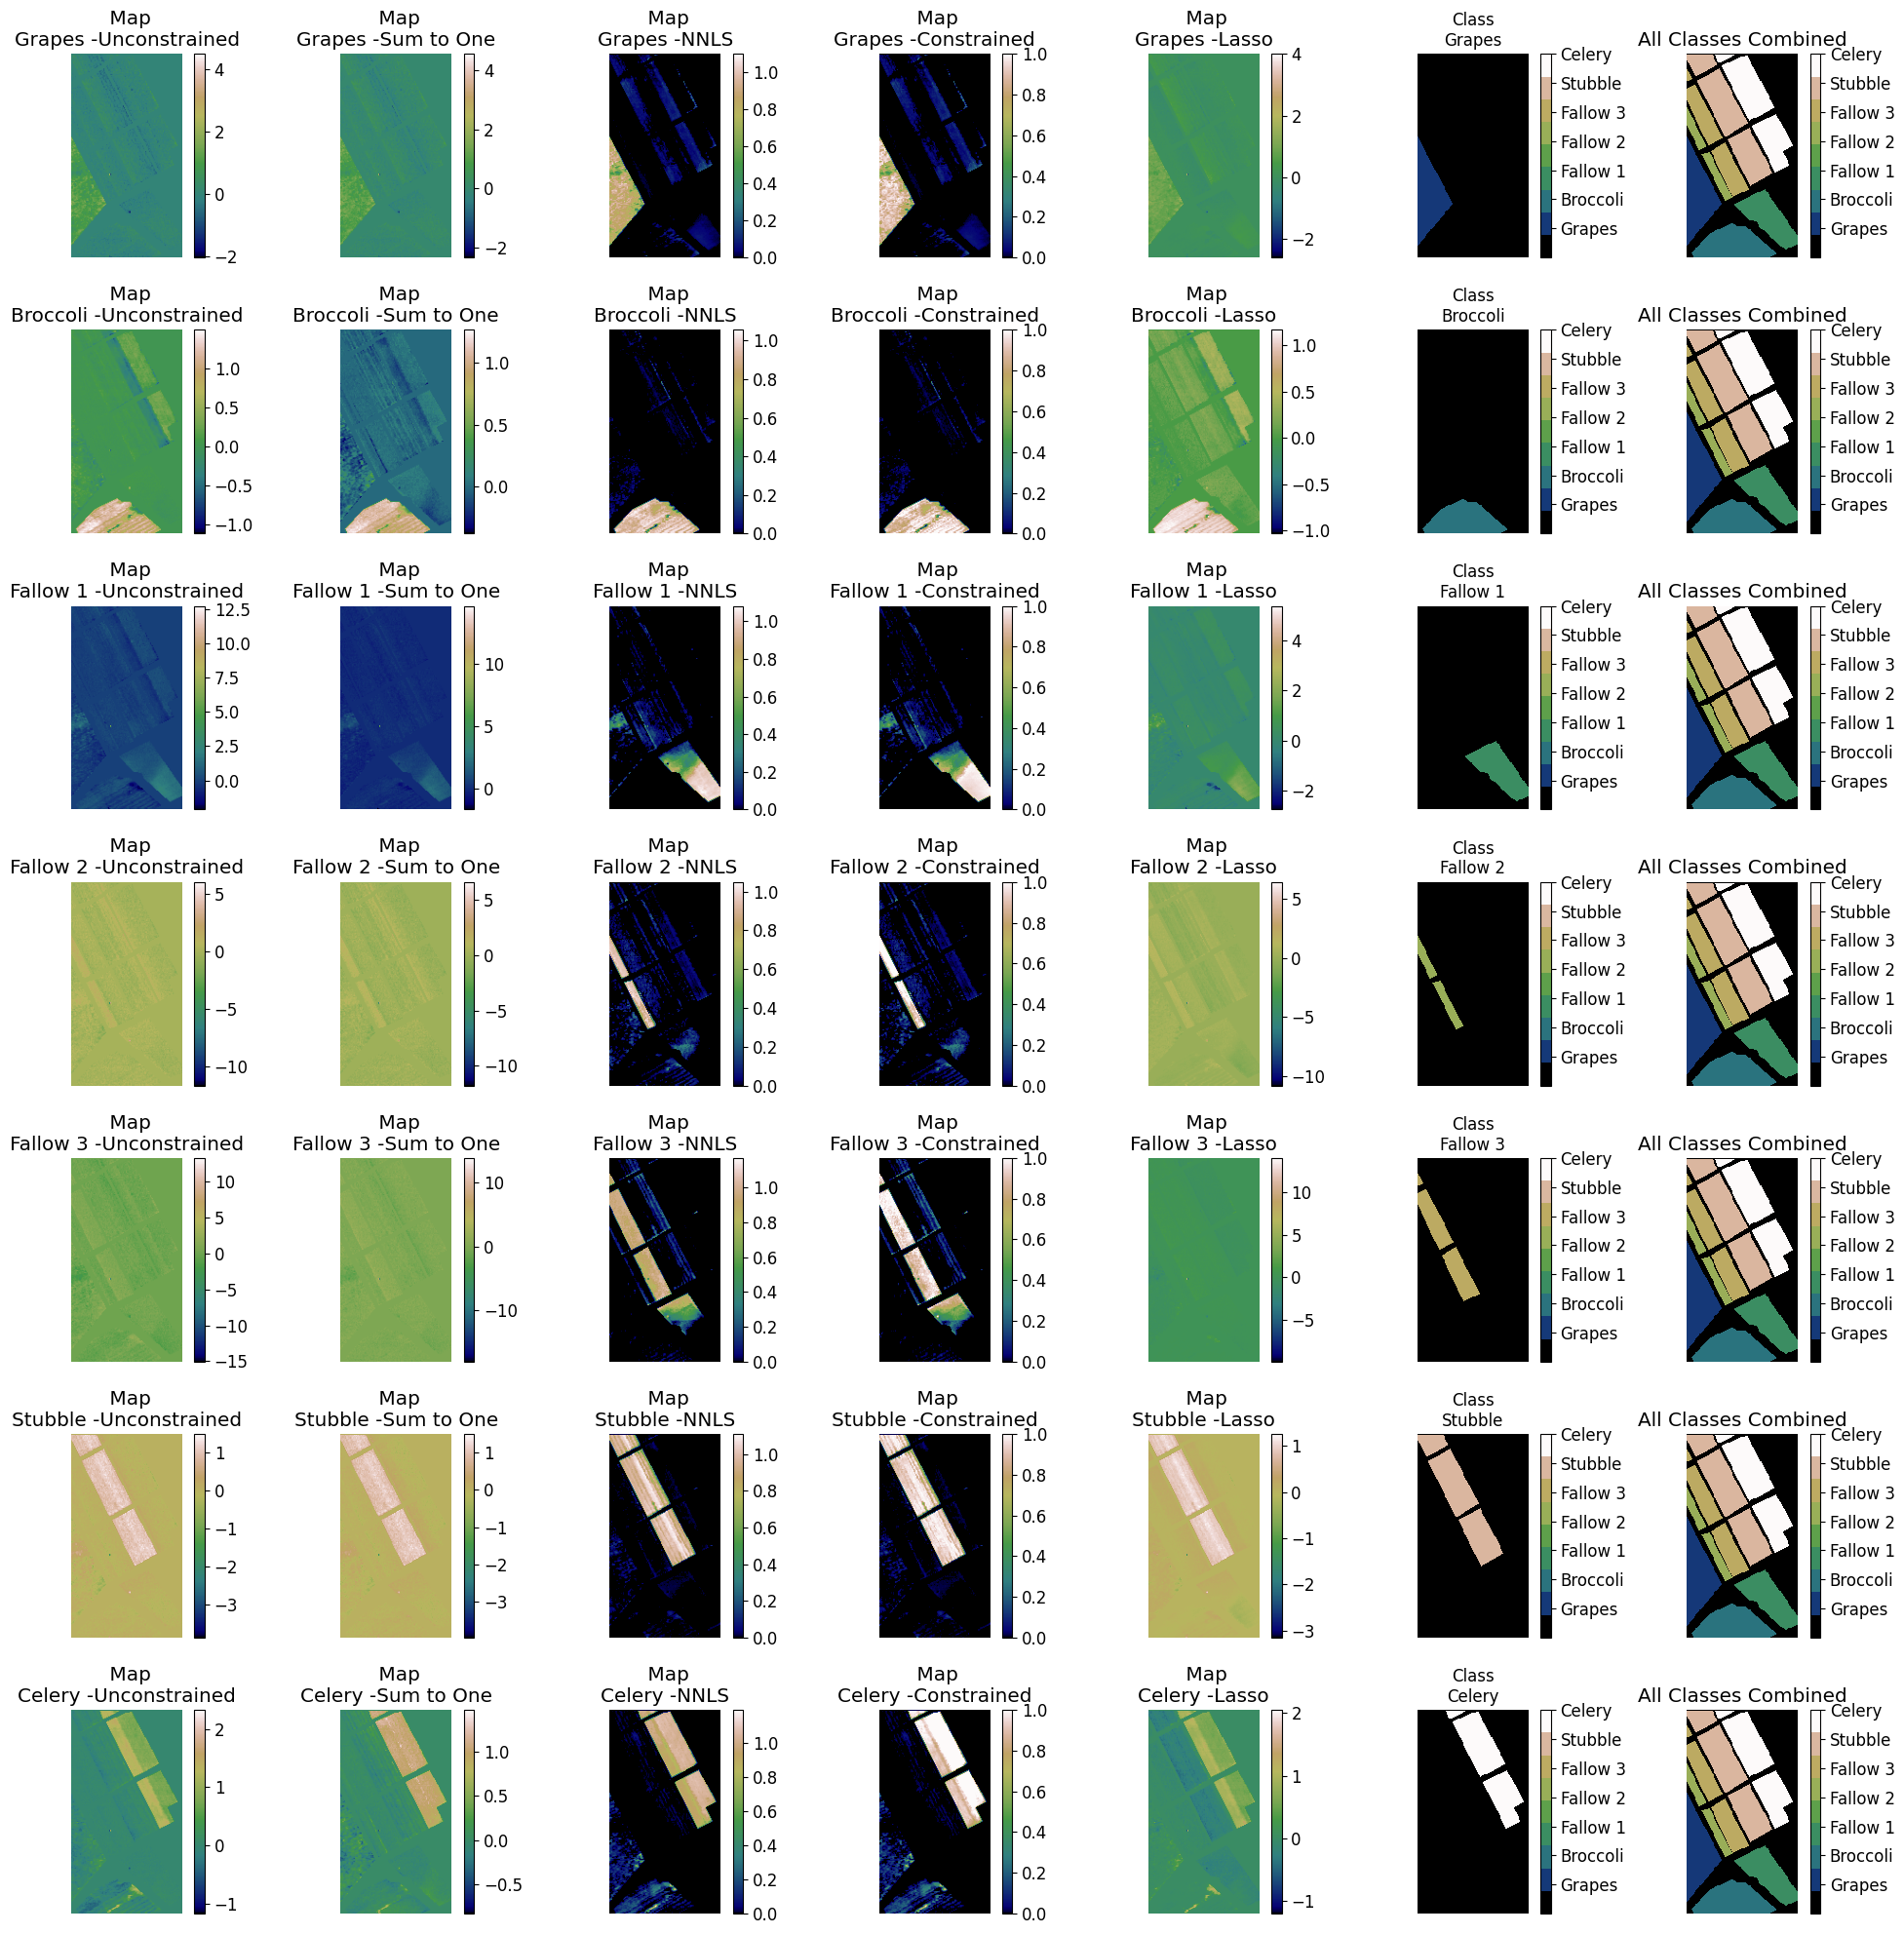

In [55]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Dimensions
num_classes = 7
methods = ["Unconstrained", "Sum to One", "NNLS", "Constrained", "Lasso"]

# List of theta maps for each method (replace these with your actual variables)
thetas_list = [
    thetas_for_each_pixel_unconstrained,
    theta_for_each_pixel_sum_to_one,
    thetas_for_each_pixel_nnls,
    thetas_for_each_pixel_constrained,
    thetas_for_each_pixel_lasso
]

# Endmember material names
endmember_materials = [
    "Grapes","Broccoli", "Fallow 1", "Fallow 2",
    "Fallow 3", "Stubble", "Celery", 
]

# Material mapping for class labels
material_mapping = {
    1: 'Grapes',
    2: 'Broccoli',
    3: 'Fallow 1',
    4: 'Fallow 2',
    5: 'Fallow 3',
    6: 'Stubble',
    7: 'Celery'
}

# Create a figure with 7 rows (for the 7 abundance maps) and 7 columns (5 methods + 1 for ground truth + 1 for combined)
fig, axs = plt.subplots(7, 7, figsize=(20, 20))

# Access the 'gist_earth' colormap directly without the deprecated function
cmap = plt.colormaps['gist_earth']  # New way to access colormap

# Create a discrete colormap with a fixed number of colors (using the 'gist_earth' colormap)
cmap_discrete = cmap(np.linspace(0, 1, num_classes + 2))

# Loop through each abundance map (1 to 7)
for k in range(7):
    for method_idx, method in enumerate(methods):  # Loop through methods
        ax = axs[k, method_idx]
        
        # Select the appropriate theta (method and abundance map)
        theta_map = thetas_list[method_idx][:, :, k]
        
        # Plot the abundance map for the k-th abundance map and method_idx-th method
        im = ax.imshow(theta_map, cmap=cmap)
        
        # Set the title for the subplot
        ax.set_title(f" Map\n{endmember_materials[k]} -{method}")
        ax.axis('off')  # Hide axes

        # Add a colorbar for each subplot
        cbar = fig.colorbar(im, ax=ax, orientation='vertical')

# Loop through each class (1 to 7)
for k in range(7):
    # Create a mask for the current class (set pixels not belonging to the current class to 0)
    class_mask = np.where(ground_truth == k + 1, k + 1, 0)  # Only show class k+1, others are set to 0
    
    # Plot each class mask in the 6th column (index 5)
    ax_class_mask = axs[k, 5]  # The 6th column for each row
    im = ax_class_mask.imshow(class_mask, cmap=plt.cm.colors.ListedColormap(cmap_discrete), interpolation='none', vmin=0, vmax=num_classes)
    
    # Set the title for each subplot (showing the class name)
    ax_class_mask.set_title(f"Class\n{material_mapping[k + 1]}", fontsize=12)
    ax_class_mask.axis('off')  # Remove axes for cleaner presentation
    
    # Add colorbar for each class mask
    cbar = fig.colorbar(im, ax=ax_class_mask, orientation='vertical')
    cbar.set_ticks(np.arange(1, num_classes + 1))  # Set ticks to class labels
    cbar.set_ticklabels([material_mapping[i] for i in range(1, num_classes + 1)])



# Create a combined mask for all classes in the 7th column (index 6)
for k in range(7):
    ax_combined = axs[k, 6]  # 7th column for combined plot
    combined_mask = np.zeros_like(ground_truth)
    
    # Combine all class masks
    for i in range(1, num_classes + 1):
        combined_mask = np.maximum(combined_mask, np.where(ground_truth == i, i, 0))
    
    im_combined = ax_combined.imshow(combined_mask, cmap=plt.cm.colors.ListedColormap(cmap_discrete), interpolation='none', vmin=0, vmax=num_classes)
    ax_combined.set_title("All Classes Combined")
    ax_combined.axis('off')  # Hide axes
    
    # Add colorbar for combined plot
    cbar_combined = fig.colorbar(im_combined, ax=ax_combined, orientation='vertical')
    cbar_combined.set_ticks(np.arange(1, num_classes + 1))  # Set ticks to class labels
    cbar_combined.set_ticklabels([material_mapping[i] for i in range(1, num_classes + 1)])

# Adjust layout to prevent overlap and make it neat
plt.tight_layout()

# Display the figure
plt.show()

##### Average errors for each method:

In [50]:
error_df

,Method,Average Error
0,Least Squares (Unconstrained),35058.88
1,Least Squares (Sum-to-One),43082.58
2,Least Squares (Non-negativity),156104.18
3,Least Squares (Non-negativity + Sum-to-One),1520302.94
4,LASSO (Sparsity),56173.23


## Conclusion

Based on the abundance maps and the average error values provided for each method, here’s a brief analysis:

**1. Least Squares (Unconstrained):**

This method has a relatively low average error of 35058.88.
The abundance maps appear smoother, indicating that the unconstrained least squares method allows for flexibility in abundance estimations without restrictions. However, the absence of constraints can lead to physically unrealistic values, especially when negative or values above one are encountered.

**2.Least Squares (Sum-to-One):**

This method enforces the sum of abundances to be one for each pixel, with an average error of 43082.58.
The abundance maps are still smooth but show slight variation compared to the unconstrained case. While this constraint improves interpretability, it introduces some additional error due to the summing constraint, as seen in the slightly higher average error.

**3.Least Squares (Non-negativity):**

With an average error of 156104.18, this method has a higher error than the previous two.
Enforcing non-negativity allows only non-negative abundance values, which aligns with the physical reality of abundance maps but sacrifices accuracy. The maps are sparse, but the constraints restrict flexibility, leading to higher reconstruction errors.

**4.Least Squares (Non-negativity + Sum-to-One):**

This method has the highest error at 1520302.94.
Combining both non-negativity and sum-to-one constraints is the most restrictive and leads to very sparse maps. This method enforces realistic abundance values but significantly reduces reconstruction accuracy due to the constraints, as seen in the high average error.

**5.LASSO (Sparsity):**

LASSO enforces sparsity and yields an average error of 56173.23, which is moderate compared to the other methods.
The abundance maps are sparse, indicating that LASSO effectively identifies dominant materials per pixel while reducing noise. However, the sparsity constraint leads to a moderate reconstruction error.

<h3>Summary:</h3>
Unconstrained Least Squares provides the lowest error but lacks realistic abundance interpretation.
Sum-to-One and Non-negativity constraints improve physical interpretability but increase error.
LASSO balances sparsity and reconstruction quality well, offering interpretable abundance maps with moderate error.